# Figures for Adding EHR Data with Raw Count of ICD-9 & CPT  

In [32]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import pickle 
from scipy.cluster.hierarchy import linkage,leaves_list
from scipy.interpolate import interp1d
from cycler import cycler
from collections import OrderedDict 

from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:90% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
sys.path.append('/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification')
from hyperparam_tune import validate_best_model

In [3]:
import shap

In [4]:
%load_ext rpy2.ipython

In [5]:
ROOT_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-01-21_manuscript_add_ehr_data" 
BIN_CLIN_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019_09_05_add_clin_labs/bin_labs"
CLIN_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019_09_05_add_clin_labs/lab_values"
OUTPUT_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/add_ehr_data"

## Functions

In [6]:
def get_test_performance(input_file, model_file):
    
    
    input_data = pd.read_csv(input_file, sep="\t")
    print("done loading {}".format(os.path.basename(input_file)))
    
    held_out_df = input_data.loc[input_data['partition']=='held_out'].copy()
    train_df = input_data.loc[input_data['partition']=='grid_cv'].copy()
    held_out_df.set_index('GRID',inplace=True)
    train_df.set_index('GRID',inplace=True)
    
    X_test = held_out_df.iloc[:,:-2]
    y_test = held_out_df.label.apply(lambda x: 1 if x == 'preterm' else 0).values

    
    xgb_model = pickle.load(open(model_file, "rb"))
    
    return X_test, y_test, xgb_model 

In [7]:
def plot_roc(store_fpr, store_tpr, aucs, plt_prefix='', roc_fig_file=None):
    '''
    plot auroc curve(s) with mean and std; save if a roc_fig_file is provided

        INPUTS:
            * store_fpr, store_tpr, aucs: a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * roc_fig_file: full path to save file
            * savefig: boolean to save or not save figure

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating roc plot.....")

    interp_fpr = np.linspace(0, 1, 100)
    store_tpr_interp = []

    ax = plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r', label='Chance', alpha=.8)

    # plot each cv iteration
    for cv_iter, fpr_tpr_auc in enumerate(zip(store_fpr, store_tpr, aucs)):
        # set_trace()
        fpr, tpr, auc = fpr_tpr_auc
        plt.plot(fpr, tpr, lw=4, alpha=0.9, label="#{}(AUC={:.3f})".format(cv_iter, auc))

        lin_fx = interp1d(fpr, tpr, kind='linear')
        interp_tpr = lin_fx(interp_fpr)

        # store_tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
        # store_tpr_interp[-1][0] = 0.0
        store_tpr_interp.append(interp_tpr)

    # plot mean and std only if more than one curve present
    if len(store_fpr) != 1:
        # plot mean, sd, and shade in between
        mean_tpr = np.mean(store_tpr_interp, axis=0)
        # mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(interp_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(interp_fpr, mean_tpr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(store_tpr_interp, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
        plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if roc_fig_file:
        plt.savefig(roc_fig_file)
        print("\tDone. AUROC curve saved to:\n\t{}".format(roc_fig_file))

    return ax

In [8]:
def plot_pr(precisions, recalls, avg_prs, plt_prefix, pr_fig_file=None, pos_prop=None):
    ''' plot PR curve(s) with mean and std; save if pr_fig_file is provided

        INPUTS:
            * precisions, recalls, avg_prs: must be a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * pr_fig_file: full path to save file
            * pos_prop: total true positives / total samples (i.e. proportion of positves)

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating PR curve plot ...")
    # mean_rc = np.linspace(0, 1, 100)
    interp_rc = np.linspace(0, 1, 100)

    store_pr_interp = []
    ax = plt.figure()

    # plot line of random chance
    if pos_prop:
        plt.plot([0, 1], [pos_prop, pos_prop], linestyle='--', lw=4,
                 color='r', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

    # plot each cv_iter
    for cv_iter, pr_rc_avg in enumerate(zip(precisions, recalls, avg_prs)):

        pr_array, rc_array, pr_avg = pr_rc_avg
        # plt.plot(rc_array, pr_array, lw=1, color='k', alpha=0.4)
        plt.step(rc_array, pr_array, lw=4, alpha=0.8, where='post', label="#{}(AvgPR={:.3f})".format(cv_iter, pr_avg))

        # interpolate recall to have the same length array for taking mean
        lin_fx = interp1d(rc_array, pr_array, kind='linear')
        interp_pr = lin_fx(interp_rc)
        store_pr_interp.append(interp_pr)

    # set_trace()

    # plot mean and std only if more than one curve present
    if len(precisions) != 1:
        # mean and std
        mean_pr = np.mean(store_pr_interp, axis=0)
        mean_avg_pr = np.mean(avg_prs)
        std_avg_pr = np.std(avg_prs)

        # std of each pr-curve
        std_pr = np.std(store_pr_interp, axis=0)
        pr_upper = np.minimum(mean_pr + 2*std_pr, 1)
        pr_lower = np.maximum(mean_pr - 2*std_pr, 0)
        plt.fill_between(interp_rc, pr_lower, pr_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

        plt.plot(interp_rc, mean_pr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_avg_pr, std_avg_pr), lw=2, alpha=0.8)

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if pr_fig_file:
        plt.savefig(pr_fig_file)
        print("\tPR curve saved to:\n\t{}".format(pr_fig_file))

    return ax

## Load Data 

In [9]:
dataset_dict = OrderedDict()
for dlabel in ['age_race','obnotes','prs','unstruc' ,'bin_labs','clin_labs']: 
    
    for flabel in ['all','icd_cpt', 'only']:

        if dlabel == 'bin_labs':
               
            input_file = glob.glob(BIN_CLIN_DATA_DIR+'/*/input_data_vs_{}_{}*'.format(dlabel, flabel) )[0]
            model_file = glob.glob(BIN_CLIN_DATA_DIR+'/*/best_xgb_model_vs_{}_{}*'.format(dlabel,flabel))[0]

        elif dlabel == 'clin_labs': 
            input_file = glob.glob(CLIN_DATA_DIR+'/*/input_data_vs_{}_{}*'.format(dlabel, flabel) )[0]
            model_file = glob.glob(CLIN_DATA_DIR+'/*/best_xgb_model_vs_{}_{}*'.format(dlabel,flabel))[0]

        else: 

            input_file = glob.glob(ROOT_DATA_DIR+'/*/input_data_vs_{}__{}*'.format(dlabel,flabel))[0]
            model_file = glob.glob(ROOT_DATA_DIR+'/*/best_xgb_model_vs_{}__{}*'.format(dlabel,flabel))[0]

        dataset_dict['{}_{}'.format(dlabel,flabel)] =  {'input_file': input_file, 'model_file': model_file}


In [10]:
STORED_DATA_FILE = os.path.join(OUTPUT_DIR,'add_ehr_datasets_dict_with_labs.pickle')

In [11]:
# load if the data already exists... 

if os.path.isfile(STORED_DATA_FILE):     
    print("loading pickled file...")
    metrics_file = open(STORED_DATA_FILE, 'rb')
    dataset_dict = pickle.load(metrics_file)
else: 
    print("creating data...")
    store_results = {}
    for label, inner_dict in dataset_dict.items(): 

        print(label)
        X_test, y_test, xgb_model  = get_test_performance(inner_dict['input_file'], inner_dict['model_file'])
        metrics_results, metrics_df, model_params = validate_best_model(xgb_model, X_test, y_test)

        dataset_dict[label]['metrics_df'] = metrics_df
        dataset_dict[label]['metrics_results'] = metrics_results
        dataset_dict[label]['y_test'] = y_test
        dataset_dict[label]['X_test'] = X_test

loading pickled file...


In [12]:
#  save stored dictionary
if not os.path.isfile(STORED_DATA_FILE): 
    pickle.dump(dataset_dict, open(STORED_DATA_FILE, 'wb'))    
    print("pickled model.")

## Create metrics dataframe

In [13]:
# concat metrics_df 
all_metrics_df = pd.DataFrame()
for label, inner_dict in dataset_dict.items(): 
    
    print(label)
    metrics_df = inner_dict['metrics_df']
#     metrics_df['dataset'] = mod_labels[label]
    metrics_df['dataset'] = label
    all_metrics_df = all_metrics_df.append(metrics_df)

age_race_all
age_race_icd_cpt
age_race_only
obnotes_all
obnotes_icd_cpt
obnotes_only
prs_all
prs_icd_cpt
prs_only
unstruc_all
unstruc_icd_cpt
unstruc_only
bin_labs_all
bin_labs_icd_cpt
bin_labs_only
clin_labs_all
clin_labs_icd_cpt
clin_labs_only


In [14]:
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('all') > -1) else False), 'model'] = 'all'
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('only') > -1) else False), 'model'] = 'only'
all_metrics_df.loc[all_metrics_df['dataset'].apply(lambda x: True if (x.find('icd_cpt') > -1) else False), 'model'] = 'baseline'


all_metrics_df['data'] = all_metrics_df['dataset'].apply(lambda x: x.replace('_all','').replace('_icd_cpt','').replace('_only',''))

In [15]:
all_metrics_df['random_pr'] = (all_metrics_df.tp_count + all_metrics_df.fn_count)/all_metrics_df.total_count

In [16]:
all_metrics_df.head()

,precision,recall,f1,roc_auc,avg_pr,tn_count,fp_count,fn_count,tp_count,brier_score,total_count,dataset,model,data,random_pr
0,0.753876,0.804273,0.778259,0.947556,0.863059,4882,381,284,1167,0.073213,6714,age_race_all,all,age_race,0.216116
0,0.756270,0.810476,0.782435,0.949259,0.867206,4884,379,275,1176,0.072467,6714,age_race_icd_cpt,baseline,age_race,0.216116
0,0.254864,0.451413,0.325790,0.567973,0.255310,3348,1915,796,655,0.247490,6714,age_race_only,only,age_race,0.216116
0,0.542254,0.836957,0.658120,0.923297,0.791065,385,65,15,77,0.111939,542,obnotes_all,all,obnotes,0.169742
0,0.635514,0.739130,0.683417,0.915411,0.781074,411,39,24,68,0.078857,542,obnotes_icd_cpt,baseline,obnotes,0.169742


In [17]:
all_metrics_df.dataset.unique()

array(['age_race_all', 'age_race_icd_cpt', 'age_race_only', 'obnotes_all',
       'obnotes_icd_cpt', 'obnotes_only', 'prs_all', 'prs_icd_cpt',
       'prs_only', 'unstruc_all', 'unstruc_icd_cpt', 'unstruc_only',
       'bin_labs_all', 'bin_labs_icd_cpt', 'bin_labs_only',
       'clin_labs_all', 'clin_labs_icd_cpt', 'clin_labs_only'],
      dtype=object)

In [18]:
# new lables 
mod_labels = {'age_race_all':'ICD+CPT+age_race', 'age_race_icd_cpt':'ICD+CPT', 'age_race_only':'age_race',
              'obnotes_all':'ICD+CPT+obnotes', 'obnotes_icd_cpt':'ICD+CPT', 'obnotes_only':'obnotes',
              'prs_all':'ICD+CPT+prs', 'prs_icd_cpt':'ICD+CPT', 'prs_only':'prs',
              'unstruc_all':'ICD+CPT+unstruc', 'unstruc_icd_cpt':'ICD+CPT', 'unstruc_only':'unstruc',
              'bin_labs_all':'ICD+CPT+binary_labs', 'bin_labs_icd_cpt':'ICD+CPT', 'bin_labs_only':'binary_labs',
              'clin_labs_all':'ICD+CPT+labs', 'clin_labs_icd_cpt':'ICD+CPT', 'clin_labs_only':'labs'
             }

## Save Data for Plotting

## AUC ROC 

In [19]:
sns.set( style='whitegrid',  font_scale=1.2, rc={'figure.figsize':(8*6,8)} )
sns.set_style( {'axes.grid': True, 'axes.edgecolor': 'k', 'font.sans-serif': ['Arial'], 'grid.color': '#e1e1e1'})
plt.rc('axes', prop_cycle=(cycler('color', ['#1b9e77', '#d95f02', '#7570b3']) ))
fsize=20
leg_fsize=8

In [20]:
%matplotlib inline

figure saved to:/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/add_ehr_data/2019-10-09_roc_add_ehr.pdf


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


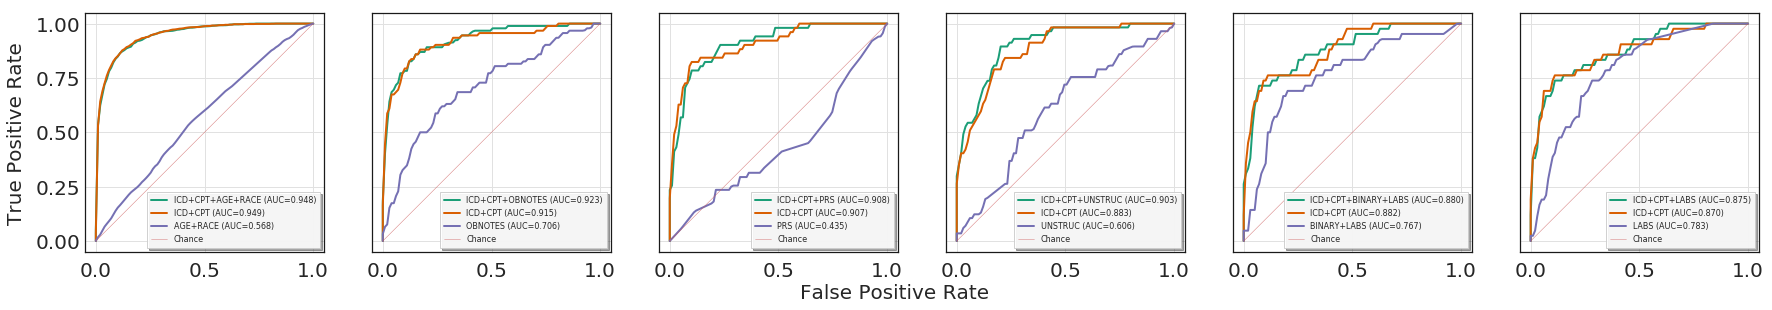

In [21]:
roc_data_df = pd.DataFrame()
## ROC PLOTS
fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(5*6,5))
_ = fig.text(0.5, 0.04, 'False Positive Rate', ha='center', fontsize=fsize)
_ = fig.text(0.089, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize=fsize)

interp_fpr = np.linspace(0, 1, 100)
for index, label_dict in enumerate(dataset_dict.items()): 
    label, inner_dict = label_dict

    # unpack data 
    metrics_results = inner_dict['metrics_results']
    fpr = metrics_results['fpr']
    tpr = metrics_results['tpr']
    auc = metrics_results['roc_auc']
    
    # calc 
    lin_fx = interp1d(fpr, tpr, kind='linear', assume_sorted=True)
    interp_tpr = lin_fx(interp_fpr)
    
    # force a 0,0 start 
    interp_fpr = np.hstack((np.array([0]), interp_fpr))
    interp_tpr = np.hstack((np.array([0]), interp_tpr))
    
    #plot
    _ = axes[int(index/3)].plot(interp_fpr, interp_tpr, lw=2, alpha=1, linestyle='-',
                 label="{} (AUC={:.3f})".format(mod_labels[label].upper().replace("_","+"), auc))
    
    
    # force equal aspect 
    axes[int(index/3)].set_aspect(1)
    
    if index % 3 == 2: 
        _ = axes[int(index/3)].plot([0, 1], [0, 1], linestyle='-', lw=0.5, color='#CD5C5C', label='Chance', alpha=.8)    
        _ = axes[int(index/3)].tick_params(axis='both', which='major', labelsize=fsize)
        
    _ = axes[int(index/3)].legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)

        
ax = fig.get_axes()[0]
ax.tick_params(axis='y', size=1)


roc_fig_file = os.path.join(OUTPUT_DIR, '{}_roc_add_ehr.pdf'.format(DATE))
print("figure saved to:{}".format(roc_fig_file))
plt.savefig(roc_fig_file)

## PR AUC 

figure saved to:/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/add_ehr_data/2019-10-09_pr_roc_add_ehr.pdf


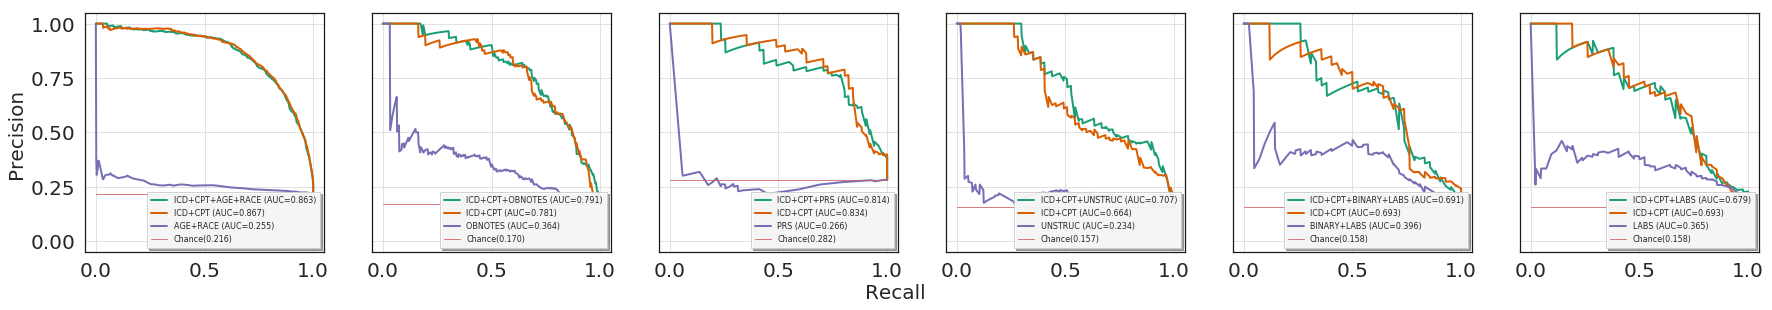

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(5*6,5))
_ = fig.text(0.5, 0.04, 'Recall', ha='center', fontsize=fsize)
_ = fig.text(0.089, 0.5, 'Precision', va='center', rotation='vertical', fontsize=fsize)

interp_rc = np.linspace(0, 1, 500)

for index, label_dict in enumerate(dataset_dict.items()): 
    
    
    label, inner_dict = label_dict
    # get data 
    metrics_results = inner_dict['metrics_results']
    pr = metrics_results['pr_curve']
    rc = metrics_results['rc_curve']
    pr_auc = metrics_results['avg_prec']
    
    # TO DO: update this number 
    pos_prop=np.sum(inner_dict['y_test'])/len(inner_dict['y_test'])
    
    # calc 
    lin_fx = interp1d(rc, pr, kind='linear')
    interp_pr = lin_fx(interp_rc)
    
    # force a 1,pos_prop end
    interp_rc = np.hstack((interp_rc, np.array([1])))
    interp_pr = np.hstack((interp_pr, np.array([pos_prop])))
    
    _ = axes[int(index/3)].plot(interp_rc, interp_pr, lw=2, alpha=1, linestyle='-',
                 label="{} (AUC={:.3f})".format(mod_labels[label].upper().replace("_","+"), pr_auc))

    axes[int(index/3)].set_aspect(1)
    if index % 3 == 2:
        _ = axes[int(index/3)].plot([0, 1], [pos_prop, pos_prop], linestyle='-', lw=1,
                 color='#CD5C5C', label='Chance({:.3f})'.format(pos_prop), alpha=.8)
        _ = axes[int(index/3)].set_xlim([-0.05, 1.05])
        _ = axes[int(index/3)].set_ylim([-0.05, 1.05])
        _ = axes[int(index/3)].tick_params(axis='both', which='major', labelsize=fsize)
        
    _ = axes[int(index/3)].legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)


pr_fig_file = os.path.join(OUTPUT_DIR, '{}_pr_roc_add_ehr.pdf'.format(DATE))
print("figure saved to:{}".format(pr_fig_file))
plt.savefig(pr_fig_file)

## PR ROC Barplots

In [23]:
all_metrics_df.head()
rand_pr_dict = dict(zip(all_metrics_df.dataset, all_metrics_df.random_pr))

,precision,recall,f1,roc_auc,avg_pr,tn_count,fp_count,fn_count,tp_count,brier_score,total_count,dataset,model,data,random_pr
0,0.753876,0.804273,0.778259,0.947556,0.863059,4882,381,284,1167,0.073213,6714,age_race_all,all,age_race,0.216116
0,0.756270,0.810476,0.782435,0.949259,0.867206,4884,379,275,1176,0.072467,6714,age_race_icd_cpt,baseline,age_race,0.216116
0,0.254864,0.451413,0.325790,0.567973,0.255310,3348,1915,796,655,0.247490,6714,age_race_only,only,age_race,0.216116
0,0.542254,0.836957,0.658120,0.923297,0.791065,385,65,15,77,0.111939,542,obnotes_all,all,obnotes,0.169742
0,0.635514,0.739130,0.683417,0.915411,0.781074,411,39,24,68,0.078857,542,obnotes_icd_cpt,baseline,obnotes,0.169742


In [24]:
# melt dataframe
melted_metrics_df = pd.melt(all_metrics_df, id_vars=['model', 'data','dataset'], value_vars=['roc_auc','avg_pr'] )
melted_metrics_df.variable = melted_metrics_df.variable.str.upper()


In [25]:
melted_metrics_df.sort_values('dataset')

,model,data,dataset,variable,value
0,all,age_race,age_race_all,ROC_AUC,0.947556
18,all,age_race,age_race_all,AVG_PR,0.863059
1,baseline,age_race,age_race_icd_cpt,ROC_AUC,0.949259
19,baseline,age_race,age_race_icd_cpt,AVG_PR,0.867206
2,only,age_race,age_race_only,ROC_AUC,0.567973
20,only,age_race,age_race_only,AVG_PR,0.255310
30,all,bin_labs,bin_labs_all,AVG_PR,0.690795
12,all,bin_labs,bin_labs_all,ROC_AUC,0.879783
31,baseline,bin_labs,bin_labs_icd_cpt,AVG_PR,0.692777
13,baseline,bin_labs,bin_labs_icd_cpt,ROC_AUC,0.882122


In [26]:
random_df = melted_metrics_df.copy()
# udpate random expected value 
random_df.loc[random_df['variable']=='ROC_AUC', 'value'] = 0.50 
random_df.loc[random_df['variable']=='AVG_PR', 'value'] = random_df.loc[random_df['variable']=='AVG_PR', 'dataset'].map(rand_pr_dict)

In [27]:
rand_pr_dict
random_df

{'age_race_all': 0.21611557938635687,
 'age_race_icd_cpt': 0.21611557938635687,
 'age_race_only': 0.21611557938635687,
 'obnotes_all': 0.16974169741697417,
 'obnotes_icd_cpt': 0.16974169741697417,
 'obnotes_only': 0.16974169741697417,
 'prs_all': 0.281767955801105,
 'prs_icd_cpt': 0.281767955801105,
 'prs_only': 0.281767955801105,
 'unstruc_all': 0.1574585635359116,
 'unstruc_icd_cpt': 0.1574585635359116,
 'unstruc_only': 0.1574585635359116,
 'bin_labs_all': 0.15789473684210525,
 'bin_labs_icd_cpt': 0.15789473684210525,
 'bin_labs_only': 0.15789473684210525,
 'clin_labs_all': 0.15789473684210525,
 'clin_labs_icd_cpt': 0.15789473684210525,
 'clin_labs_only': 0.15789473684210525}

,model,data,dataset,variable,value
0,all,age_race,age_race_all,ROC_AUC,0.500000
1,baseline,age_race,age_race_icd_cpt,ROC_AUC,0.500000
2,only,age_race,age_race_only,ROC_AUC,0.500000
3,all,obnotes,obnotes_all,ROC_AUC,0.500000
4,baseline,obnotes,obnotes_icd_cpt,ROC_AUC,0.500000
5,only,obnotes,obnotes_only,ROC_AUC,0.500000
6,all,prs,prs_all,ROC_AUC,0.500000
7,baseline,prs,prs_icd_cpt,ROC_AUC,0.500000
8,only,prs,prs_only,ROC_AUC,0.500000
9,all,unstruc,unstruc_all,ROC_AUC,0.500000


In [28]:
rand_pr_dict

{'age_race_all': 0.21611557938635687,
 'age_race_icd_cpt': 0.21611557938635687,
 'age_race_only': 0.21611557938635687,
 'obnotes_all': 0.16974169741697417,
 'obnotes_icd_cpt': 0.16974169741697417,
 'obnotes_only': 0.16974169741697417,
 'prs_all': 0.281767955801105,
 'prs_icd_cpt': 0.281767955801105,
 'prs_only': 0.281767955801105,
 'unstruc_all': 0.1574585635359116,
 'unstruc_icd_cpt': 0.1574585635359116,
 'unstruc_only': 0.1574585635359116,
 'bin_labs_all': 0.15789473684210525,
 'bin_labs_icd_cpt': 0.15789473684210525,
 'bin_labs_only': 0.15789473684210525,
 'clin_labs_all': 0.15789473684210525,
 'clin_labs_icd_cpt': 0.15789473684210525,
 'clin_labs_only': 0.15789473684210525}

In [29]:
#attempt plot in python

In [30]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

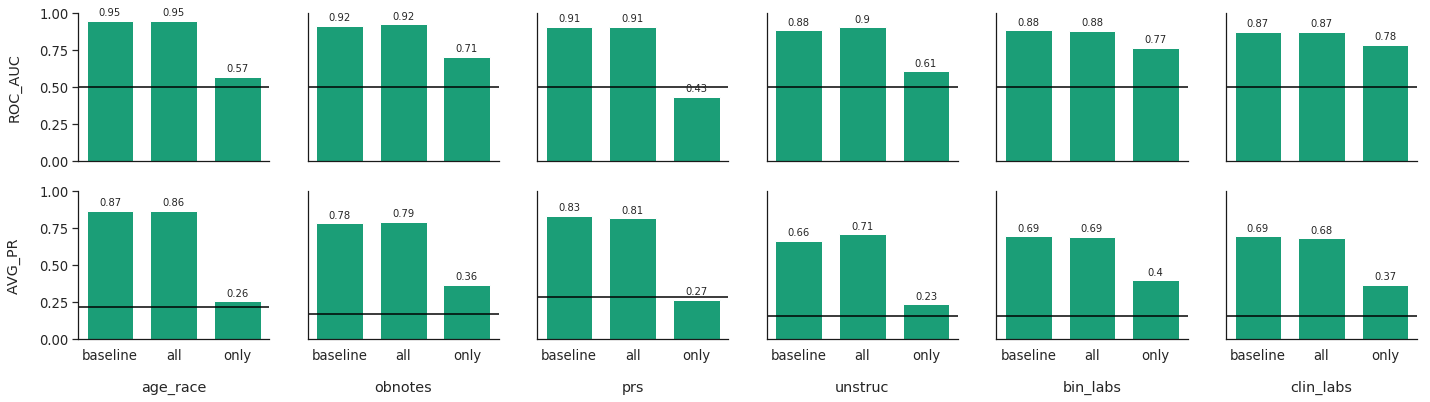

In [37]:
row_labels = melted_metrics_df.variable.unique().tolist()
col_labels = melted_metrics_df.data.unique().tolist()
x_model_labels =  ['baseline','all','only']
x_coords = [0, 0.75, 1.5]

width = 0.55  # the width of the bars

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(4*6,6), sharex=True, sharey=True)

for row in range(len(row_labels)): 
    for col in range(len(col_labels)):

        col_name = col_labels[col]

        
        models = melted_metrics_df.loc[  (melted_metrics_df['variable'] == row_labels[row]) & (melted_metrics_df['data'] == col_labels[col])].copy()
        
        # get y_values
        y_vals = []
        for this_model in x_model_labels: 
            y_vals.append(models.loc[models['model']==this_model, 'value'].values.tolist()[0])

        this_ax = axs[row, col]
        
        this_ax.grid(False)
        this_ax.spines['right'].set_visible(False)
        this_ax.spines['top'].set_visible(False)
        
        rects1 = this_ax.bar(x_coords, y_vals, width)
        _ = this_ax.set_ylim(0,1)

        
        autolabel(rects1, this_ax)

        if row == 1:
            _ = this_ax.set_xticks(x_coords)
            _ = this_ax.set_xticklabels(x_model_labels)
            _ = this_ax.set_xlabel(col_labels[col], labelpad=18)
            _ = this_ax.axhline(y=rand_pr_dict[col_name+"_all"], color='black')
        else: 
            _ = this_ax.axhline(y=0.5, color='black')
            
        
        if col == 0: 
            _ = this_ax.set_ylabel(row_labels[row], labelpad=18)
            _ = this_ax.set_yticks(np.arange(0,1.25,0.25))
            _ = this_ax.tick_params(axis='y', direction='out', left=True)


Make nicer plot for manuscript

In [89]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib.pyplot as plt 

In [77]:
print(matplotlib.matplotlib_fname())

/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


In [109]:
matplotlib.font_manager.fontManager.findfont('Arial.ttf',rebuild_if_missing=True, directory="/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts")

/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial.ttf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


'/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [84]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [113]:
import matplotlib.font_manager as fm

In [ ]:
# set up fonts
fpath='/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf'
prop = font_manager.FontProperties(fname=fpath)

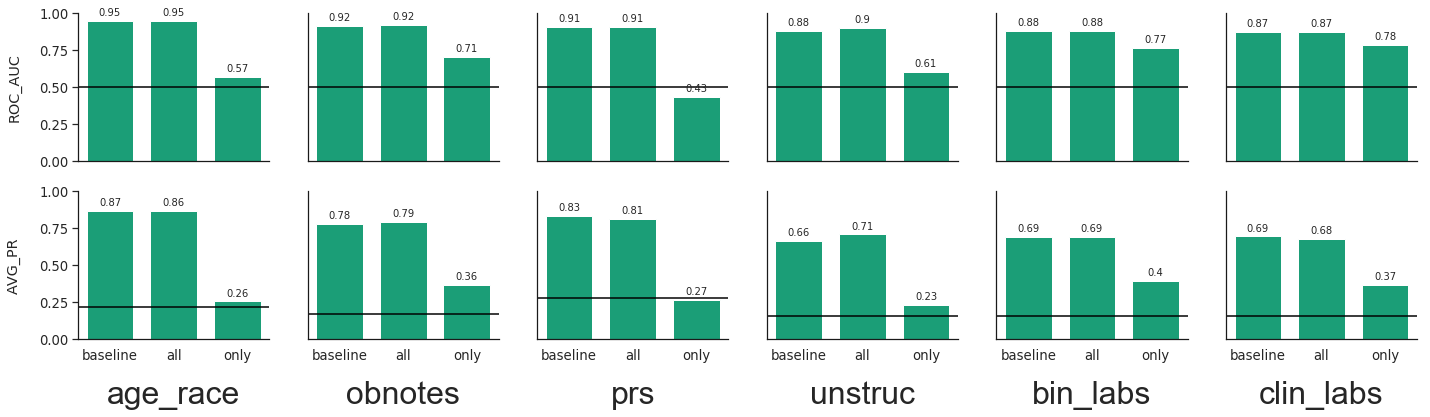

In [118]:

# matplotlib.rcParams['font'] = prop.get_name()

row_labels = melted_metrics_df.variable.unique().tolist()
col_labels = melted_metrics_df.data.unique().tolist()
x_model_labels =  ['baseline','all','only']
x_coords = [0, 0.75, 1.5]

width = 0.55  # the width of the bars

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(4*6,6), sharex=True, sharey=True)

for row in range(len(row_labels)): 
    for col in range(len(col_labels)):

        col_name = col_labels[col]

        
        models = melted_metrics_df.loc[  (melted_metrics_df['variable'] == row_labels[row]) & (melted_metrics_df['data'] == col_labels[col])].copy()
        
        # get y_values
        y_vals = []
        for this_model in x_model_labels: 
            y_vals.append(models.loc[models['model']==this_model, 'value'].values.tolist()[0])

        this_ax = axs[row, col]
        
        this_ax.grid(False)
        this_ax.spines['right'].set_visible(False)
        this_ax.spines['top'].set_visible(False)
        
        rects1 = this_ax.bar(x_coords, y_vals, width)
        _ = this_ax.set_ylim(0,1)

        
        autolabel(rects1, this_ax)

        if row == 1:
            _ = this_ax.set_xticks(x_coords)
            _ = this_ax.set_xticklabels(x_model_labels)
            _ = this_ax.set_xlabel(col_labels[col], labelpad=18, fontproperties=prop, size=32)
            _ = this_ax.axhline(y=rand_pr_dict[col_name+"_all"], color='black')
        else: 
            _ = this_ax.axhline(y=0.5, color='black')
            
        
        if col == 0: 
            _ = this_ax.set_ylabel(row_labels[row], labelpad=18)
            _ = this_ax.set_yticks(np.arange(0,1.25,0.25))
            _ = this_ax.tick_params(axis='y', direction='out', left=True)


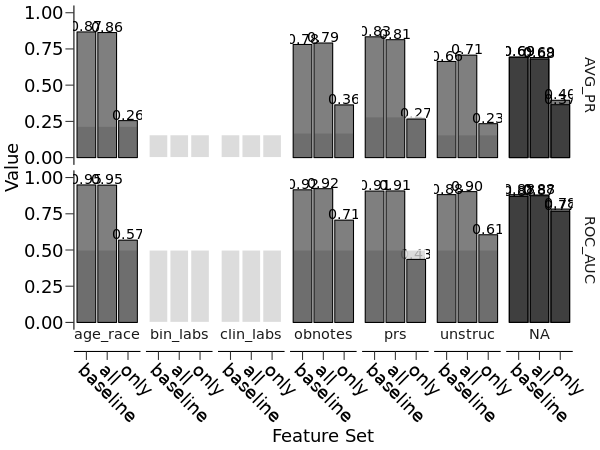

In [33]:
%%R -i melted_metrics_df -i DATE -i OUTPUT_DIR -i random_df -h 450 -w 600
### PLOT ALL DATA POINTS 
library(ggplot2)

# order factors
melted_metrics_df$data <-factor(melted_metrics_df$data, levels = c("age_race","obnotes","prs", "unstruc"))
melted_metrics_df$model <-factor(melted_metrics_df$model, levels = c("baseline","all","only"))
melted_metrics_df$variable <-factor(melted_metrics_df$variable, levels = c("ROC_AUC",'AVG_PR'))

mplt = ggplot(data = melted_metrics_df, aes(x=model, y=value, label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_text(aes(y = value + 0.04), position =position_dodge(0.9), size = 5, angle=0) 


mplt = mplt + facet_grid(variable~data,switch="x")
# rand = rand + facet_grid(variable~data)

mplt = mplt + geom_bar(data=random_df, stat="identity",  position="dodge",fill="lightgray", color="white", alpha=0.8)
mplt = mplt + geom_bar(stat="identity",  position="dodge", color="black", fill="black", alpha=0.5)


# mplt = mplt + scale_fill_manual(values=c('#1b9e77', '#d95f02', '#7570b3'))
mplt = mplt + xlab("Feature Set")
mplt = mplt + ylab("Value")
mplt = mplt + ylim(c(0,1))

mplt = mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    axis.text.x = element_text(angle=315, hjust=0),
    legend.position="none",
    strip.background = element_rect(colour="white", fill="white"),
    strip.text=element_text(vjust=2.7))
mplt


# fig_file =  sprintf('%s-roc_pr_auc_barplot-add_ehr.eps',DATE)
# sprintf("File saved t %s", fig_file)
# ggsave(fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

## F1, PR, and Recall 

In [56]:
all_metrics_df.head()

,precision,recall,f1,roc_auc,avg_pr,tn_count,fp_count,fn_count,tp_count,brier_score,total_count,dataset,model,data
0,0.753876,0.804273,0.778259,0.947556,0.863059,4882,381,284,1167,0.073213,6714,age_race_all,all,age_race
0,0.756270,0.810476,0.782435,0.949259,0.867206,4884,379,275,1176,0.072467,6714,age_race_icd_cpt,baseline,age_race
0,0.254864,0.451413,0.325790,0.567973,0.255310,3348,1915,796,655,0.247490,6714,age_race_only,only,age_race
0,0.542254,0.836957,0.658120,0.923297,0.791065,385,65,15,77,0.111939,542,obnotes_all,all,obnotes
0,0.635514,0.739130,0.683417,0.915411,0.781074,411,39,24,68,0.078857,542,obnotes_icd_cpt,baseline,obnotes


In [160]:
# melt dataframe
melted_metrics_df = pd.melt(all_metrics_df, id_vars=['model', 'data'], value_vars=['precision','recall','f1'] )
melted_metrics_df.variable = melted_metrics_df.variable.str.upper()
melted_metrics_df.head(10)
melted_metrics_df.data.unique()
melted_metrics_df.model.unique()
melted_metrics_df.variable.unique()

,model,data,variable,value
0,all,age_race,PRECISION,0.753876
1,baseline,age_race,PRECISION,0.756270
2,only,age_race,PRECISION,0.254864
3,all,obnotes,PRECISION,0.542254
4,baseline,obnotes,PRECISION,0.635514
5,only,obnotes,PRECISION,0.292079
6,all,prs,PRECISION,0.794872
7,baseline,prs,PRECISION,0.837209
8,only,prs,PRECISION,0.240741
9,all,unstruc,PRECISION,0.540984


array(['age_race', 'obnotes', 'prs', 'unstruc'], dtype=object)

array(['all', 'baseline', 'only'], dtype=object)

array(['PRECISION', 'RECALL', 'F1'], dtype=object)

### bar plot

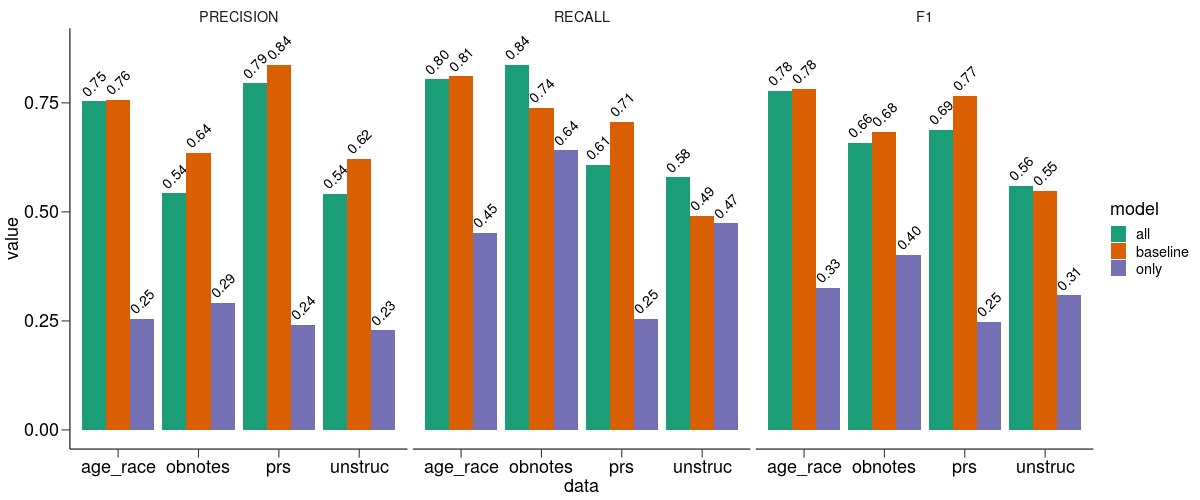

In [162]:
%%R -i melted_metrics_df  -h 500 -w 1200
### PLOT ALL DATA POINTS 
library(ggplot2)

melted_metrics_df$data <-factor(melted_metrics_df$data, levels = c("age_race","obnotes","prs", "unstruc"))


melted_metrics_df$variable <-factor(melted_metrics_df$variable, 
                                levels = c("PRECISION",'RECALL','F1'))

mplt = ggplot(data = melted_metrics_df, aes(x=data, y=value, fill=model,  
                                          label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_text(aes(y = value + 0.04), position =position_dodge(0.9), size = 5, angle=45) 



mplt = mplt + facet_grid(~variable)
mplt = mplt + geom_bar(stat="identity",  position="dodge")
# # might have to fix this manual scale 
mplt = mplt + scale_fill_manual(values=c('#1b9e77', '#d95f02', '#7570b3'))
# mplt = mplt + xlab("Feature Set")
# mplt = mplt + ylab("Value")
# mplt = mplt + ylim(c(0,1))

mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
#     legend.position="none",
    strip.background = element_rect(colour="white", fill="white"))

### faceted barplot

In [174]:
%%R -i melted_metrics_df -i DATE -i OUTPUT_DIR -h 400 -w 1200
### PLOT ALL DATA POINTS 
library(ggplot2)

melted_metrics_df$data <-factor(melted_metrics_df$data, levels = c("age_race","obnotes","prs", "unstruc"))


melted_metrics_df$variable <-factor(melted_metrics_df$variable, 
                                levels = c("PRECISION",'RECALL','F1'))

mplt = ggplot(data = melted_metrics_df, aes(x=model, y=value, 
                                          label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_text(aes(y = value + 0.04), position =position_dodge(0.9), size = 5, angle=45) 



mplt = mplt + facet_wrap(variable~data, nrow=1)
mplt = mplt + geom_bar(stat="identity",  position="dodge")
# # might have to fix this manual scale 
mplt = mplt + scale_fill_manual(values=c('#1b9e77', '#d95f02'))
# mplt = mplt + xlab("Feature Set")
# mplt = mplt + ylab("Value")
# mplt = mplt + ylim(c(0,1))

mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    axis.text.x = element_text(angle=315, hjust=0),
    legend.position="none",
    strip.background = element_rect(colour="white", fill="white"))

# fig_file =  sprintf('%s-f1_pr_rc_barplot-add_ehr.pdf',DATE)
sprintf("File saved t %s", fig_file)
ggsave(fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

### Dumbell plot

In [175]:
# change to wide form
wide_metrics_df = melted_metrics_df.groupby(['data', 'variable', 'model'])['value'].sum().unstack('model').reset_index()
wide_metrics_df.head()

model,data,variable,all,baseline,only
0,age_race,F1,0.778259,0.782435,0.325790
1,age_race,PRECISION,0.753876,0.756270,0.254864
2,age_race,RECALL,0.804273,0.810476,0.451413
3,obnotes,F1,0.658120,0.683417,0.401361
4,obnotes,PRECISION,0.542254,0.635514,0.292079


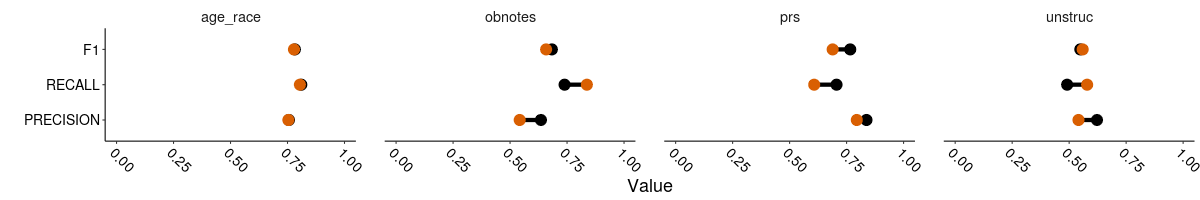

In [177]:
%%R -i wide_metrics_df  -h 200 -w 1200
### PLOT ALL DATA POINTS 
library(ggplot2)
library("ggalt")
wide_metrics_df$data <-factor(wide_metrics_df$data, levels = c("age_race","obnotes","prs", "unstruc"))


wide_metrics_df$variable <-factor(wide_metrics_df$variable, 
                                levels = c("PRECISION",'RECALL','F1'))


gg <- ggplot(wide_metrics_df, aes(y=variable, x=baseline, xend=all)) + 
    geom_dumbbell(size_x=5, size_xend=5, 
                color="black", size=2,
                colour_x = "black", colour_xend = "#d95f02",
                shape=19, shape_end=25,
                show.legend=TRUE )
gg = gg + facet_grid(~data)


gg = gg + xlab("Value") + ylab("") + xlim(c(0,1))
gg = gg + theme_classic() + theme( 
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=14, family="arial", color="black"),
    axis.text.x = element_text(angle=315, hjust=0),
    strip.background = element_rect(colour="white", fill="white"))

gg = gg +  theme(panel.spacing = unit(2, "lines"))
gg


## Brier Score Bar Plot

In [179]:
all_metrics_df.head()

,precision,recall,f1,roc_auc,avg_pr,tn_count,fp_count,fn_count,tp_count,brier_score,total_count,dataset,model,data,random_pr
0,0.753876,0.804273,0.778259,0.947556,0.863059,4882,381,284,1167,0.073213,6714,age_race_all,all,age_race,0.216116
0,0.756270,0.810476,0.782435,0.949259,0.867206,4884,379,275,1176,0.072467,6714,age_race_icd_cpt,baseline,age_race,0.216116
0,0.254864,0.451413,0.325790,0.567973,0.255310,3348,1915,796,655,0.247490,6714,age_race_only,only,age_race,0.216116
0,0.542254,0.836957,0.658120,0.923297,0.791065,385,65,15,77,0.111939,542,obnotes_all,all,obnotes,0.169742
0,0.635514,0.739130,0.683417,0.915411,0.781074,411,39,24,68,0.078857,542,obnotes_icd_cpt,baseline,obnotes,0.169742


In [182]:
# melt dataframe
melt_brier_df = pd.melt(all_metrics_df, id_vars=['model', 'data'], value_vars=['brier_score'] )
melt_brier_df.variable = melt_brier_df.variable.str.upper()
melt_brier_df.head(10)


,model,data,variable,value
0,all,age_race,BRIER_SCORE,0.073213
1,baseline,age_race,BRIER_SCORE,0.072467
2,only,age_race,BRIER_SCORE,0.247490
3,all,obnotes,BRIER_SCORE,0.111939
4,baseline,obnotes,BRIER_SCORE,0.078857
5,only,obnotes,BRIER_SCORE,0.234623
6,all,prs,BRIER_SCORE,0.113279
7,baseline,prs,BRIER_SCORE,0.106396
8,only,prs,BRIER_SCORE,0.379291
9,all,unstruc,BRIER_SCORE,0.088310


In [191]:
%%R  -i melt_brier_df -i OUTPUT_DIR -i DATE
library(ggplot2)

# order labels 
melt_brier_df$model <-factor(melt_brier_df$model, levels = c("baseline", "all","only"))

barplt = ggplot(data = melt_brier_df,
                aes(x=model, y=value, 
                label=sprintf("%0.3f", round(value, digits = 3)))) 

barplt = barplt + geom_bar(stat="identity")
barplt =barplt + geom_text(aes(y = value + 0.018), size = 5, angle = 48, position = position_dodge(0.9))


barplt = barplt + facet_grid(~data)

# barplt = barplt + scale_fill_manual(values= c( "#balck", "#d95f02"))
barplt = barplt + ylab("Brier Score")
# barplt = barplt + xlab("Feature Set")



barplt = barplt + theme_classic() + theme(
    text = element_text(size=13, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    axis.text.x = element_text(angle=315, hjust=0),
    strip.background = element_rect(colour="white", fill="white"),
    strip.text.x = element_text(size=12, family="arial", color="black", face="plain"),
    axis.title.y = element_text(size=18, family="arial", color="black"),
    legend.position="none")

barplt
pr_fig_file =  sprintf('%s-brier-add_ehr.pdf',DATE)
ggsave(pr_fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

## Feature Importance 

In [ ]:
# TO DO 